In [1]:
from dotenv import load_dotenv
import os

load_dotenv()

os.environ["GROQ_API_KEY"] = os.getenv("GROQ_API_KEY")
os.environ["TAVILY_API_KEY"]=os.getenv("TAVILY_API_KEY")
os.environ['HF_TOKEN']=os.getenv("HF_TOKEN")

In [ ]:
from pydantic import BaseModel, Field
from langchain_core.output_parsers import BaseOutputParser
import re
import json

class RobustPydanticParser(BaseOutputParser):
    def __init__(self, pydantic_object):
        super().__init__()
        self._pydantic_object = pydantic_object

    def parse(self, text):
        match = re.search(r"\{.*\}", text, re.DOTALL)
        if not match:
            raise ValueError("No JSON object found in LLM output")
        json_str = match.group(0)
        json_str = json_str.replace("\\'", "'")
        try:
            data = json.loads(json_str)
        except Exception:
            # Fallback: replace single quotes with double quotes
            data = json.loads(re.sub(r"'", '"', json_str))
        return self._pydantic_object.model_validate(data)
    
    def get_format_instructions(self) -> str:
        return (
            "Respond ONLY with a valid JSON object using double quotes for all keys and string values. "
            "The object must have the following fields:\n"
            "  - Category: one of 'economical', 'medium', or 'expensive'\n"
            "  - Reasoning: a string explaining the classification\n"
            "Example:\n"
            '{\n  "Category": "expensive",\n  "Reasoning": "Nike shoes are generally priced above $100, placing them in the expensive category as the final price exceeds $100."\n}'
        )    
    
class Product(BaseModel):
    Category:str = Field(description="category of product (economical, medium, expensive)")
    Reasoning:str = Field(description="reasoning behind category selection")    

parser = RobustPydanticParser(Product)

In [ ]:
from typing import TypedDict, Annotated, Sequence
from langchain_core.messages import BaseMessage
import operator

class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], operator.add]
    validation: Annotated[Sequence[BaseMessage], operator.add]

In [72]:

from langchain_huggingface import HuggingFaceEmbeddings
embeddings = HuggingFaceEmbeddings(model_name="BAAI/bge-small-en-v1.5")

In [73]:
from langchain.document_loaders.csv_loader import CSVLoader

loader = CSVLoader("walmart-products.csv", encoding="utf-8")
documents = loader.load()

from langchain_community.vectorstores import FAISS

vector_store = FAISS.from_documents(documents, embeddings)
retriever = vector_store.as_retriever(search_type="similarity", search_kwargs={"k": 1})

In [14]:
from langchain_groq import ChatGroq

model = ChatGroq(model="qwen-qwq-32b")

In [308]:
import re
from langchain.prompts import PromptTemplate
from langchain_core.output_parsers import StrOutputParser

str_parser = StrOutputParser()

def remove_think_tags(response):
    """
    Removes <think>...</think> blocks from a string and returns the rest, stripped of leading/trailing whitespace.
    """
    text = str(response)
    cleaned = re.sub(r'<think>.*?</think>', '', text, flags=re.DOTALL|re.IGNORECASE)
    return cleaned.strip()

def supervisor(state: AgentState):
    print("<-- Supervisor -->")
    print(f'state= {state}')
    if not state.get("validation")[-1]:
        return {"messages": ["Search"]}

    question = state["messages"][-1]
    print(f'question= {question}')

    template="""
        Your task is check if the question is for the ecommerce product or a person. 
        If it is for the proudct then determine if the given 'question' is product in Walmart and if it is then return Walmart.
        
        Respond ONLY with string 'Walmart', 'Amazon' or 'Search'. Do not include any thing or other content.

        question: {question}
    """


    prompt = PromptTemplate(
        template = template,
        input_variables=["question"],
    )

    chain = prompt | model | str_parser

    resp = chain.invoke({"question": question})
    # print(resp)
    answer = remove_think_tags(resp)

    return {"messages": [answer]}

In [240]:
supervisor({"messages": ["Hello"]})

<-- Supervisor -->
state= {'messages': ['Hello']}
question= Hello

<think>
Okay, let's tackle this query. The user said "Hello". First, I need to determine if this is a question about an ecommerce product or a person. "Hello" is just a greeting, so it's not asking about a product. Since it's not a product-related question, I shouldn't check Walmart or Amazon. The instructions say to respond with 'Search' if it's neither. So the answer here should be Search.
</think>

Search


{'messages': ['Search']}

In [291]:
from langchain.prompts import PromptTemplate

def llm_node(state: AgentState):
    print("<-- LLM Call-->")
    print(f'state= {state}')

    product = state["messages"][-1]
    print(f'product= {product}')

    template="""
        Your task is to classify the given 'product' into one of the following categories: [economical, medium, expensive].
        The product is economical if its final price is less than 50.
        The product is medium if its final price is between 51 and 100. 
        The product is expensive if its final price is between greater than 100. 
        
        Respond ONLY with a valid JSON object matching this format:
        {{
        "Category": "<economical|medium|expensive>",
        "Reasoning": "<your reasoning here>"
        }}

       Respond ONLY with a valid JSON object using double quotes for all keys and string values. Do NOT use single quotes or backslash escapes. Do not include newline char like '\n' in the respopnse. Do not include any other text, markdown, or explanation.

        product: {product}
        {format_instructions}
    """


    prompt = PromptTemplate(
        template = template,
        input_variables=["product"],
        partial_variables = {"format_instructions": parser.get_format_instructions()}
    )

    chain = prompt | model | parser

    resp = chain.invoke({"product": product})

    return {"messages": [resp.Category]}

In [191]:
llm_node({"messages": ["Bose Headphone"]})

<-- LLM -->
state= {'messages': ['Bose Headphone']}
product= Bose Headphone


{'messages': ['expensive']}

In [292]:
from langchain_core.runnables import RunnablePassthrough
import re

def rag_node(state: AgentState):
    print("<-- RAG Call -->")
    product = state["messages"][0]
    print(product)

    prompt = PromptTemplate(
        template="""You are a ecommerce catalog search assitant. Use the following pieces of retrieved context to answer the product details. If you don't 
        know the answer, respond that 'I don't know', nothing extra. Use three sentences maximum and keep the response concise. \nProduct: {product} \nContext: {context} 
        \n Answer:

        These are comma separated fields in the context. Please include 'final price' in the response.
        timestamp,url,final_price,sku,currency,gtin,specifications,image_urls,top_reviews,rating_stars,related_pages,available_for_delivery,available_for_pickup,brand,breadcrumbs,category_ids,review_count,description,product_id,product_name,review_tags,category_url,category_name,category_path,root_category_url,root_category_name,upc,tags,main_image,rating,unit_price,unit,aisle,free_returns,sizes,colors,seller,other_attributes,customer_reviews,ingredients,initial_price,discount,ingredients_full,categories
        """,
        input_variables=['context', 'product']
    )

    rag_chain = (
        {"context": retriever, "product": RunnablePassthrough()}
        | prompt
        | model
        | StrOutputParser()
    )

    rag_response = rag_chain.invoke(product)
    # print(rag_response)
    result = remove_think_tags(rag_response)
    # print(result)
    return {"messages": [result]}

In [245]:
# rag_node({"messages": ["Nike Men Shoe"]})
# rag_node({"messages": ["FUBU Shoe"]})
rag_node({"messages": ["Toothbursh"]})

<-- RAG Call -->
Toothbursh


{'messages': ['Parodontax Active Gum Repair Whitening Toothpaste (3.4 oz) is an enamel-safe paste aiding gum repair and whitening, priced at $11.01 (final price) after a $1.97 discount from $12.98, with a 4.6/5 rating from 485 reviews.']}

In [311]:
from langchain_community.tools import TavilySearchResults

def web_search_node(state: AgentState):
    print("<-- Web Search -->")
    question = state["messages"][0]

    tool = TavilySearchResults()

    resp = tool.invoke(question)
    return {"messages": [resp]}

In [203]:
web_search_node({"messages": ["how are you"]})

<-- Web Search -->


{'messages': [[{'title': 'How Are You? | Emotions Song | Wormhole Learning - Songs For Kids',
    'url': 'https://www.youtube.com/watch?v=O13gITUS5t4&pp=0gcJCf0Ao7VqN5tD',
    'content': "Hi, Judy. How are you?\n Hi, Judy. How are you?\n I am happy!\n Yes, I am happy!\n \n Hi, Bobby. How are you?\n Hi, Bobby. How are you?\n I am sad. \n Yes, I am sad.\n \nOh, don't be sad, Bobby!\n\n Hi, Judy. How are you?\n Hi, Judy. How are you?\n I am angry! \n Yes, I am angry!\n \nHumph!\n\n Hi, Bobby. How are you?\n Hi, Bobby. How are you?\n I am hungry! \n Yes, I am hungry!\n \nHere, Bobby. Have my ice cream.\nThank you! Now I am full. [...] Hi, children. How are you?\n Hi, children. How are you?\n I'm happy!   \n I'm sad! \n I'm angry!   \n I'm hungry! \n I'm happy!   \n I'm sad! \n I'm angry!   \n I'm hungry! \n\n[All music by Alfred Henshaw-Hill, © Copyright Wormhole Learning, 2022] [...] hi judy how are you i am happy let's sing a song hi judy how are you hi judy how are you i am happy [Music

In [300]:
def router(state: AgentState):
    print("<-- Router -->")
    last_message = state["messages"][-1]
    print(f'{last_message=}')

    if "walmart" in last_message.lower():
        return "RAG Call"
    elif "amazon" in last_message.lower():
        return "LLM Call"
    return "Web Search Call"

def validator(state: AgentState) -> bool:
    print("<-- Validator -->")
    print(state["messages"][-1])
    if "don't know" in state["messages"][-1]:
        return {"validation": [False]}
    else:
        return {"validation": [True]}

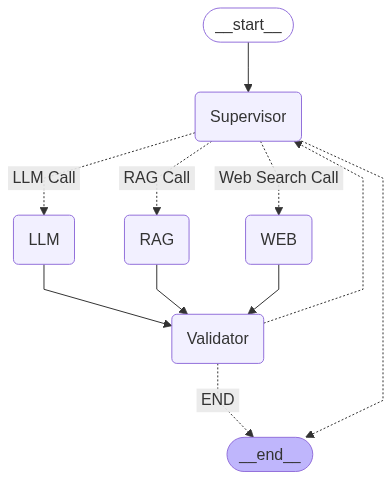

In [312]:
from langgraph.graph import StateGraph
from IPython.display import display, Image

workflow = StateGraph(AgentState)

workflow.add_node("Supervisor", supervisor)
workflow.add_node("RAG", rag_node)
workflow.add_node("LLM", llm_node)
workflow.add_node("WEB", web_search_node)
workflow.add_node("Validator", validator)

workflow.set_entry_point("Supervisor")

workflow.add_conditional_edges(
    "Supervisor",
    router,
    {
        "RAG Call": "RAG",
        "LLM Call": "LLM",
        "Web Search Call": "WEB",
    }
)

workflow.add_edge("RAG", "Validator")
workflow.add_edge("LLM", "Validator")
workflow.add_edge("WEB", "Validator")

workflow.add_conditional_edges(
    "Validator",
    lambda state: "END" if state.get("validation")[-1] else "Supervisor",
    {
        "END": "__end__",
        "Supervisor": "Supervisor"
    }
)

app = workflow.compile()

display(Image(app.get_graph().draw_mermaid_png()))

In [313]:
app.invoke({"messages": ["Nike Shoe for Men"], "validation": [True]})

<-- Supervisor -->
state= {'messages': ['Nike Shoe for Men'], 'validation': [True]}
question= Nike Shoe for Men
<-- Router -->
last_message='Walmart'
<-- RAG Call -->
Nike Shoe for Men
<-- Validator -->
I don't know. The retrieved context describes FUBU Men's Knight Basketball High-Top Shoes, not Nike shoes. Final price for the FUBU shoes is $26.
<-- Supervisor -->
state= {'messages': ['Nike Shoe for Men', 'Walmart', "I don't know. The retrieved context describes FUBU Men's Knight Basketball High-Top Shoes, not Nike shoes. Final price for the FUBU shoes is $26."], 'validation': [True, False]}
<-- Router -->
last_message='Search'
<-- Web Search -->
<-- Validator -->
[{'title': 'Mens Lifestyle Shoes. Nike.com', 'url': 'https://www.nike.com/w/mens-lifestyle-shoes-13jrmznik1zy7ok', 'content': "- [Nike Air](https://www.nike.com/air)\n  - [Nike Air Force 1](https://www.nike.com/air-force-1)\n  - [Nike Air Max](https://www.nike.com/air-max)\n  - [Nike FlyEase](https://www.nike.com/flyease)\n 

{'messages': ['Nike Shoe for Men',
  'Walmart',
  "I don't know. The retrieved context describes FUBU Men's Knight Basketball High-Top Shoes, not Nike shoes. Final price for the FUBU shoes is $26.",
  'Search',
  [{'title': 'Mens Lifestyle Shoes. Nike.com',
    'url': 'https://www.nike.com/w/mens-lifestyle-shoes-13jrmznik1zy7ok',
    'content': "- [Nike Air](https://www.nike.com/air)\n  - [Nike Air Force 1](https://www.nike.com/air-force-1)\n  - [Nike Air Max](https://www.nike.com/air-max)\n  - [Nike FlyEase](https://www.nike.com/flyease)\n  - [Nike Flyknit](https://www.nike.com/flyknit)\n  - [Nike Free](https://www.nike.com/free)\n  - [Nike React](https://www.nike.com/react)\n  - [Nike Vaporfly](https://www.nike.com/running/vaporfly)\n  - [Nike ZoomX](https://www.nike.com/zoomx)\n  - [Space Hippie](https://www.nike.com/space-hippie) [...] [Nike P-6000](https://www.nike.com/t/p-6000-mens-shoes-XkgpKW/IH0246-320)[![Nike P-6000 Men's Shoes](https://static.nike.com/a/images/c_limit,w_592,